<a href="https://colab.research.google.com/github/Rajesh2015/Credit-Card-Transaction-Sql-Analysis/blob/main/IP_Stock_Market_News_Sentiment_Analysis_and_Summarization_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

## Objective

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

## Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative


## Installing the necessary libraries

In [1]:
!pip install --upgrade --upgrade-strategy eager numpy gensim zeugma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 14.4 MB/s eta 0:00:00
   ━━━

## Importing the necessary libraries

In [1]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# to create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# to import Word2Vec
from gensim.models import Word2Vec

# to split data into train and test sets
from sklearn.model_selection import train_test_split

# to build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# to compute metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# To tune different models
from sklearn.model_selection import GridSearchCV
import kagglehub
from gensim.models import KeyedVectors


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


###  Styling

In [13]:
#  store pellete for future use
pellete='Set2'
colors = sns.color_palette(pellete)  # Get Set2 color palette for future use
sns.set(style="darkgrid") # Set grid style

## Loading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# loading data into a pandas dataframe
stocks_news = pd.read_csv("/content/drive/MyDrive/Python Course_shared/NLP/stock_news.csv")

In [114]:
# creating a copy of the data
data = stocks_news.copy()

## Data Overview

In [6]:
# Show how the data looks like on fileds level
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


### Observations:
There are around 8 coulmns
- There are 2 object datatypes.
- There are 4 float64 datatypes.
- There are 2 int64 datatypes.


---
Date seems to be of object type which we should consider converting as date


In [7]:
# dataframe shape
data.shape

(349, 8)

### Observations:
349 data points in dataset

### Checking the first five rows of the data

In [5]:
# Show first 5 records
data.head(5)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


### Fews stats and null value check

In [8]:
# Dataframe Stats
data.describe()

,Open,High,Low,Close,Volume,Label
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000


In [9]:
#Check null value
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


### Observations:
No Null values

In [11]:
data.duplicated().sum()

0

### Observations:
No Duplicate value

In [12]:
data.nunique()

,0
Date,71
News,349
Open,70
High,70
Low,71
Close,71
Volume,71
Label,3


In [123]:
data['Label'].unique()

array([-1,  0,  1])

### Observations:
- 349 distint news
- Three Labels present (-1,0,1)

### Utils

In [14]:
def plot_bar_chart_percentage(df, column_name, xlabel, pellete, bar_width=0.6):
    """
    Plots the percentage distribution of a specified categorical column in a DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: The name of the column to analyze.
    - colors: List of colors for the bar plot.
    - figsize: Tuple specifying the figure size.
    - bar_width: Width of the bars in the bar plot.
    """
    # Calculate the percentage of each category in the specified column
    percentages = df[column_name].value_counts(normalize=True)*100
    percentages = percentages.reset_index().rename(columns={ column_name: column_name, 'proportion': 'percent'})
    n=df[column_name].nunique()
    # Increase figure size for better readability
    plt.figure(figsize=(n+1,6))

    # Plot the bar plot with reduced bar width
    ax=sns.barplot(x=column_name, y='percent', data=percentages, palette=pellete,hue=column_name, width=bar_width)

    # Annotate the plot with the count values
    annotate_chart(plt, ax)

    # Set labels and title
    plt.ylabel('Percentage')
    plt.xlabel(xlabel)
    plt.title(f'Overview of {xlabel}')
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.legend([],[], frameon=False)
    plt.show()


In [15]:
def plot_pie_chart_with_legend(df, column, title=None, colors=None):
    """
    Creates a pie chart with a legend showing the share of each category in a column.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - column (str): The column name for which the pie chart will be created.
    - title (str, optional): Title of the pie chart. Default is "Market Segment Proportions".
    - colors (list, optional): List of colors for the pie chart wedges. If not provided, default pastel colors will be used.

    Returns:
    - plt (matplotlib.pyplot): The matplotlib plot object.
    """
    # Calculate proportions
    proportions = df[column].value_counts(normalize=True)

    # Create the pie chart without annotations
    plt.pie(proportions, labels=None, colors=colors, wedgeprops={'edgecolor': 'white'})

    # Generate legend labels with percentages
    legend_labels = [f'{label}: {percent:.1%}' for label, percent in zip(proportions.index, proportions)]

    # Add the legend
    plt.legend(legend_labels, loc='best', title=column.replace('_', ' ').title())

    # Add title and adjust layout
    plt.title(title)
    plt.tight_layout()

    # Return the plot
    return plt

In [16]:
def plot_histogram_and_boxplot(df, column, xlabel, ylabel, title):
    """
    Plots a histogram with KDE and a box plot for a specified column in a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    column (str): The column name for which the plots are to be drawn.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    title (str): The title for the graph.
    Returns:
    None
    """
    # Calculate percentiles
    q25 = df[column].quantile(0.25)
    q50 = df[column].quantile(0.50)
    q75 = df[column].quantile(0.75)
    mean_value = df[column].mean()
    # Create the figure and set the size
    f, (hist, box) = plt.subplots(nrows=2, sharex=True, figsize=(8, 10))

    # Create the histogram with KDE
    sns.histplot(data=df, x=column, ax=hist, kde=True, legend=True, color='lightcoral')
    hist.set_xlabel(xlabel)
    hist.axvline(mean_value, color='peru', linestyle=':', label='Mean')
    hist.axvline(q25, color='green', linestyle='--', label='25th percentile')
    hist.axvline(q50, color='blue', linestyle='-', label='50th percentile (Median)')
    hist.axvline(q75, color='purple', linestyle='--', label='75th percentile')
    hist.set_ylabel(ylabel)
    hist.legend()

    # Create the box plot in a subplot below the histogram
    sns.boxplot(data=df, x=column, ax=box, color='lightcoral')
    box.axvline(mean_value, color='peru', linestyle=':', label=f'Mean: {mean_value:.2f}')
    box.axvline(q25, color='green', linestyle='--', label=f'25th percentile: {q25:.2f}')
    box.axvline(q50, color='blue', linestyle='-', label=f'50th percentile: {q50:.2f}')
    box.axvline(q75, color='purple', linestyle='--', label=f'75th percentile: {q75:.2f}')

    # Setting the x-label and title on the shared axis and figure
    box.set_xlabel(xlabel)
    f.suptitle(title)

    # Adjust layout and show the combined plots
    f.tight_layout(rect=[0, 0, 1, 0.95])
    box.legend()  # Add legend to the box plot for the percentiles


In [17]:
def draw_count_plot(df, x, xlabel, ylabel, title, hue=None):
    """
    Draws a count plot for a specified column in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - x (str): The column name to be used for the x-axis categories.
    - xlabel (str): The label for the x-axis.
    - ylabel (str): The label for the y-axis.
    - title (str): The title for the plot.
    - hue (str, optional): The column name to be used for hue (categorical separation). Default is None.

    Returns:
    - plt (matplotlib.pyplot): The matplotlib plot object.
    """
    # Create the plot
    count=df[x].nunique()
    plt.figure(figsize=(count + 1, 4))
    ax = sns.countplot(data=df, x=x, hue=hue, palette='Set2')
    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Annotate the plot with the count values
    annotate_chart(plt, ax)

    return plt

In [18]:
def annotate_chart(plot, ax):
    """
    Annotates a chart with the height of each bar.

    Parameters:
    - plot (matplotlib.pyplot): The matplotlib plot object.
    - ax (Axes): The Axes object to annotate.
    """
    for p in ax.patches:
        height = p.get_height()

        # Only annotate if height is significant, and avoid zero or near-zero annotations
        if height > 0.001:
            plot.annotate(f'{format(height, ".1f")}% ',          # Annotate with 1 decimal places
                          (p.get_x() + p.get_width() / 2., height),  # Position the annotation at the top of the bar
                          ha='center', va='center',       # Center the annotation
                          xytext=(0, 4),                  # Small offset to avoid overlapping with the bar
                          textcoords='offset points')


In [19]:
def plot_stacked_bar_with_annotations(df, x, y, normalize='index', figsize=(8, 6), show_legend=True, show_annot=True, ax=None):
    """
    Creates a stacked bar plot with pastel colors and annotates each bar with proportion values.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - x (str): The column name to be used for the x-axis categories.
    - y (str): The column name to be used for the y-axis categories.
    - normalize (str, optional): Normalizes the values to proportions. Default is 'index'.
    - figsize (tuple, optional): The size of the figure. Default is (8, 6).
    - show_legend (bool, optional): Whether to show the legend. Default is True.
    - show_annot (bool, optional): Whether to annotate the bars. Default is True.
    - ax (matplotlib.axes.Axes, optional): An existing axes object for plotting. Default is None.

    Returns:
    - ax (matplotlib.axes.Axes): The axes object containing the plot.
    """
    # Create the crosstab
    crosstab = pd.crosstab(df[x], df[y], normalize=normalize) * 100
    crosstab.round(1)
    # Create the plot on the provided ax or create a new one if ax is None
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    crosstab.plot(kind='bar', stacked=True, ax=ax, color=['#66c2a5', '#fc8d62'])

    # Add labels to the axes
    formatted_string = ' '.join(word.capitalize() for word in x.split('_'))
    ax.set_xlabel(formatted_string)
    ax.set_ylabel('Proportion' if normalize else 'Count')
    ax.set_title(f'Proportion of {y} by {x}' if normalize else f'Count of {y} by {x}')

    # Annotate the bars with proportion or count values
    if show_annot:
        for container in ax.containers:
            ax.bar_label(container, label_type='center', fmt='%.1f', labels=[f'{v:.1f}' if v > 0 else '' for v in container.datavalues])

    # Show or remove the legend based on the show_legend parameter
    if show_legend:
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))  # Adjust bbox_to_anchor for fine control
    else:
        ax.legend().remove()

    return ax


In [20]:
def create_stacked_bar_subplots(df, columns, y, n_cols=2):
    """
    Creates stacked bar subplots for the specified columns with a common legend.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - columns (list): List of column names to plot on the x-axis.
    - y (str): The column name to plot on the y-axis.
    - n_cols (int, optional): Number of columns for the subplot layout (default is 2).
    """
    n_rows = (len(columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed

    # Create a figure with adjusted size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each column and create a subplot for it
    for i, col in enumerate(columns):
        ax = axes[i]  # Get the correct axis
        plot_stacked_bar_with_annotations(df=df, x=col, y=y, ax=ax,show_legend=False)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Get the handles and labels from one of the plots (to add the common legend)
    handles, labels = axes[0].get_legend_handles_labels()

    # Add a common legend below the subplots
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    # Adjust layout to avoid overlap
    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0)

    # Show the plot
    plt.show()

In [21]:
def plot_boxplot(df, x_col, y_col, hue_col=None, title=None, xlabel=None, figsize=(8, 5), xticks_rotation=90):
    """
    Creates a box plot to visualize the relationship between variables.

    Parameters:
    - df: pandas DataFrame containing the data.
    - x_col: str, column name for the x-axis.
    - y_col: str, column name for the y-axis.
    - hue_col: str, column name for grouping by color (optional).
    - title: str, title of the plot (optional).
    - xlabel: str, label for the x-axis (optional).
    - figsize: tuple, size of the figure (default is (8, 5)).
    - xticks_rotation: int, rotation angle for x-axis tick labels (default is 90).
      Returns:
    - plt (matplotlib.pyplot): The matplotlib plot object with annotations.
    """

    plt.figure(figsize=figsize)  # Set the figure size
    bxp = sns.boxplot(data=df, x=x_col, y=y_col, hue=hue_col,palette="Set2")  # Create the box plot

    if xlabel:
        bxp.set_xlabel(xlabel)  # Set x-axis label if provided
    if title:
        bxp.axes.set_title(title)  # Set the plot title if provided

    plt.xticks(rotation=xticks_rotation)  # Rotate x-axis labels
    return plt


In [22]:
def draw_box_plot_with_legend(df, x, xlabel, color='red'):
    """
    Draws a box plot with a vertical line indicating the mean value and includes a legend.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to plot.
    - x (str): The name of the column in the DataFrame to be plotted.
    - xlabel (str): The label for the x-axis.
    - color (str, optional): The color of the box plot. Default is 'red'.

    Returns:
    - plt (matplotlib.pyplot): The matplotlib pyplot object for further customization or saving.
    """
    mean_value = df[x].mean()
    sns.boxplot(data=df, x=x, color=color)
    plt.xlabel(xlabel)
    plt.axvline(mean_value, color='green', linestyle=':', label=f'Mean: {mean_value:.2f}')
    plt.legend()
    return plt

In [72]:
def plot_box_plot_side_by_side(df, x, xlabel, category_col, color='red'):
    """
    Plots side-by-side box plots for different categories in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to plot.
    - x (str): The name of the column in the DataFrame to be plotted.
    - xlabel (str): The label for the x-axis.
    - category_col (str): The column name in the DataFrame used to categorize the data.
    - color (str, optional): The color of the box plot. Default is 'red'.

    Returns:
    - plt (matplotlib.pyplot): The matplotlib pyplot object for further customization or saving.
    """
    # Extract unique categories
    categories = df[category_col].unique()

    # Create subplots with 1 row and the number of columns equal to the number of categories
    fig, axes = plt.subplots(1, len(categories), figsize=(12, 2))

    # Loop over each category and plot
    for i, category in enumerate(categories):
        plt.sca(axes[i])  # Set the current axes
        subset = df[df[category_col] == category]
        draw_box_plot_with_legend(subset, x, xlabel, color=color)
        axes[i].set_title(f'{category.capitalize()}')

    plt.tight_layout()
    return plt

In [24]:
def create_catplot_with_annotations(df, x, hue, col, colors, height=4, aspect=1, title="Catplot with Annotations", annotation_color='b'):
    """
    Creates a catplot with count kind, a color palette, axis labels, title, and annotations.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    x (str): The name of the column for the x-axis.
    hue (str): The name of the column for hue.
    col (str): The name of the column for creating subplots.
    colors (tuple): A tuple of two colors for the palette.
    height (int): The height of each facet (default is 4).
    aspect (float): Aspect ratio of each facet (default is 1).
    title (str): The title of the plot (default is "Catplot with Annotations").
    annotation_color (str): The color of the annotations (default is 'b').
    """
    # Create the catplot
    catplot = sns.catplot(data=df, x=x, hue=hue, col=col, kind='count', height=height, aspect=aspect, palette=colors)

    # Set axis labels and title
    catplot.set_axis_labels(x, 'Count')
    catplot.set_titles(col_template="{col_name}")
    catplot.fig.suptitle(title, y=1.02)  # Title with a bit of padding

    # Add annotations with specified color
    for ax in catplot.axes.flat:
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points',
                        color=annotation_color)

In [25]:
def distribution_plot_wrt_target(data, predictor, target, xlabel1, xlabel2):
    """
    Plots the distribution of a predictor variable with respect to a target variable.

    This function creates a 2x2 grid of plots, including:
    1. Histograms with KDE for each unique value of the target variable.
    2. A boxplot showing the distribution of the predictor variable grouped by the target variable.
    3. A boxplot showing the distribution of the predictor variable grouped by the target variable without outliers.

    Parameters:
    - data (DataFrame): The input DataFrame containing the data.
    - predictor (str): The name of the predictor variable (column) to visualize.
    - target (str): The name of the target variable (column) to group the data by.
    - xlabel1 (str): Label for the x-axis of the first histogram.
    - xlabel2 (str): Label for the x-axis of the second histogram.

    Returns:
    - None: Displays the plots but does not return any values.
    """

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    # Histogram for the first unique target value
    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color=colors[0],
        stat="density",
    )
    axs[0, 0].set_xlabel(xlabel1)

    # Histogram for the second unique target value
    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color=colors[1],
        stat="density",
    )
    axs[0, 1].set_xlabel(xlabel2)

    # Boxplot with outliers
    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], color=colors[0])

    # Boxplot without outliers
    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        color=colors[1],
        showmeans=True
    )

    plt.tight_layout()
    plt.show()


## Exploratory Data Analysis (EDA)

### Univariate Analysis

In [26]:
data.columns

Index(['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label'], dtype='object')

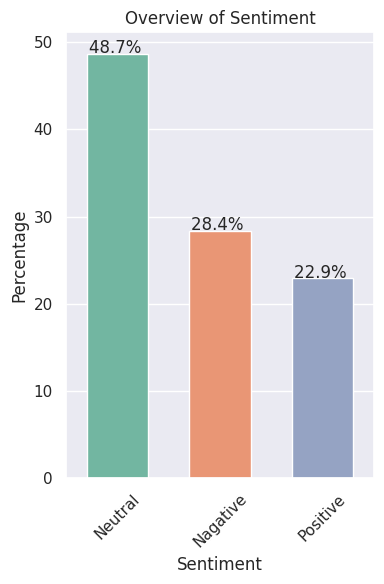

In [120]:
# Map each of these -1,0,1 to labels like Nagative,Positive and Neutral
data['sentiment_label']=data['Label'].map({1:'Positive',0:'Neutral',-1:'Nagative'})
# Plot bar chart to check the class
plot_bar_chart_percentage(df=data,column_name='sentiment_label',xlabel='Sentiment',pellete=pellete)

### Observations:
- Around 48.7% is neutral in this dataset followed by 28.4% and postive sentiments are least 22.9%
---
While doing sentiment classification we should take this one in to account

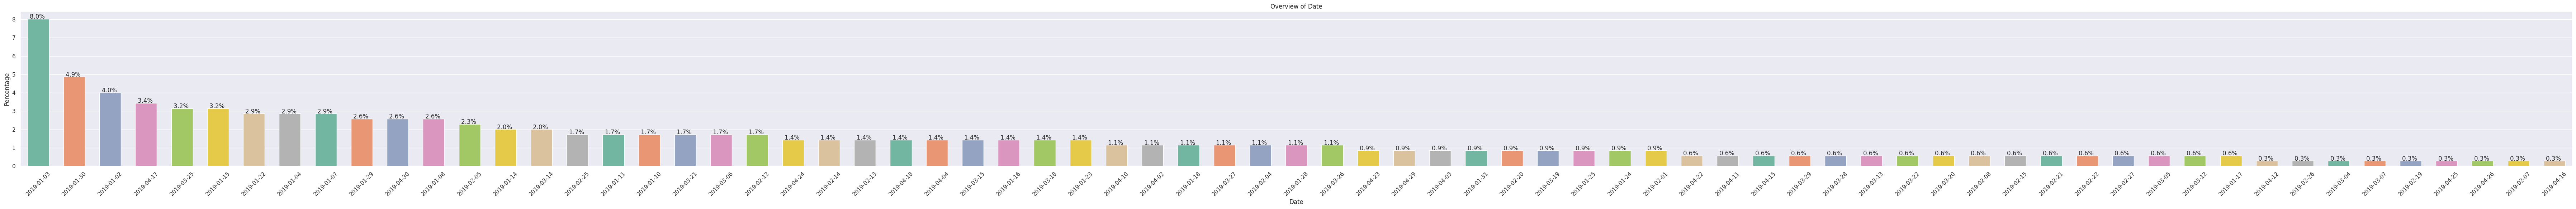

In [29]:
# Bar chart to see those data points date wise
plot_bar_chart_percentage(df=data,column_name='Date',xlabel='Date',pellete=pellete)

### Observations:
- Highest no of review from 03-01-2019 (8%) followed by 30-01-2019 (4.9%) and 02-01-2019 (4%)

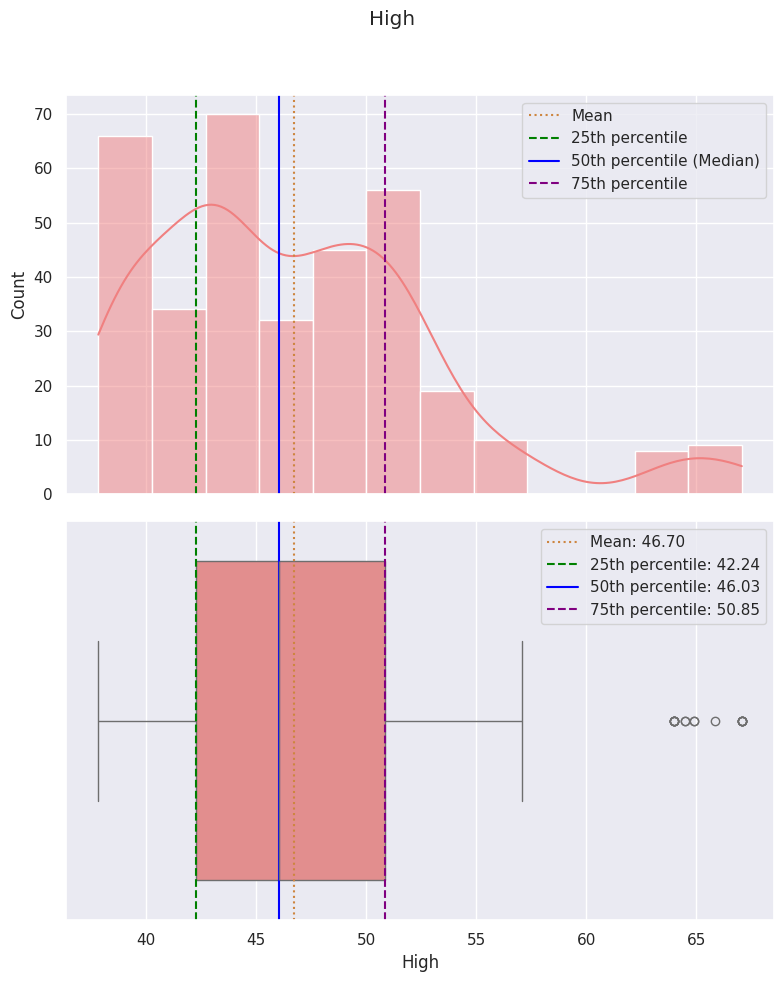

In [34]:
# Distribution of High
plot_histogram_and_boxplot(df=data,column='High',xlabel='High',ylabel='Count',title='High')

### Observations:
- We can see the distribution of Highest Stock Price is right skewed.
- The mean is at 46.7 and median is at 46.03(slight right skewed)

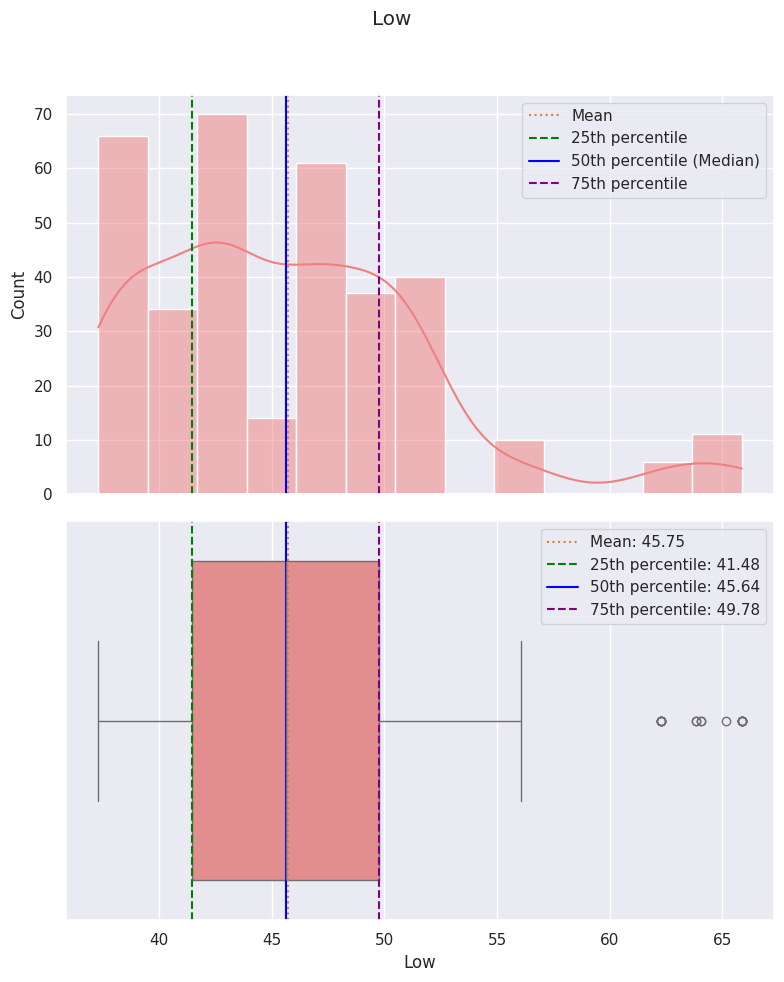

In [37]:
# DIstribution of low
plot_histogram_and_boxplot(df=data,column='Low',xlabel='Low',ylabel='Count',title='Low')

### Observations:
- Both mean and mdeian is near to each other (45.5)

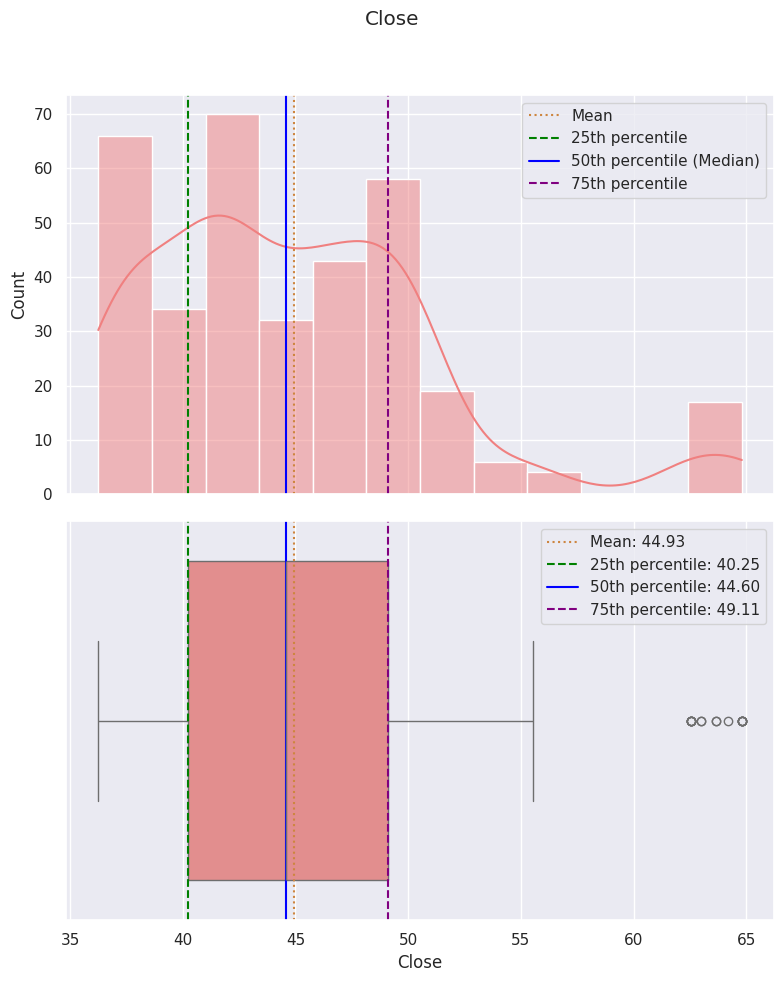

In [38]:
# Distribution of Close
plot_histogram_and_boxplot(df=data,column='Close',xlabel='Close',ylabel='Count',title='Close')

### Observations:
-  Close price is right skewed slightly with mean at 44.93 and median at 44.6

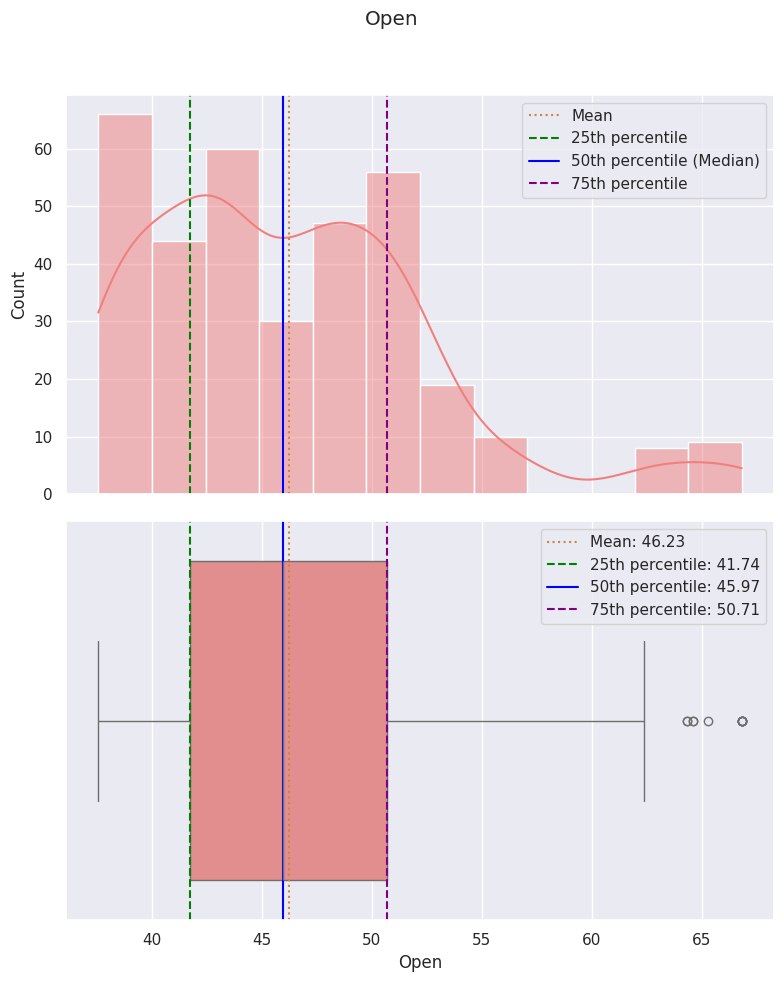

In [39]:
# Distribution of Open
plot_histogram_and_boxplot(df=data,column='Open',xlabel='Open',ylabel='Count',title='Open')

### Observations:
- Open price is slighly right skewed as well with Mean at 46.2 and Mdeian at 45.9

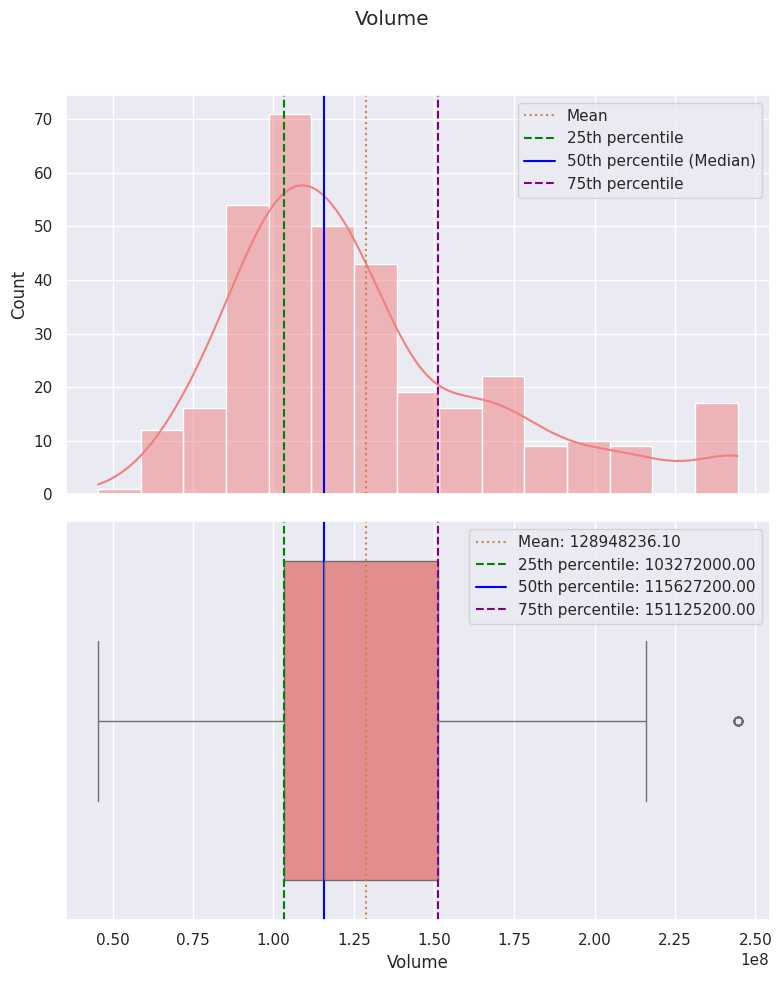

In [41]:
#Distribution of volume
plot_histogram_and_boxplot(df=data,column='Volume',xlabel='Volume',ylabel='Count',title='Volume')

### Observations:
- The distribution of volume is right skewed with mean is pull towards right where as median at left of it.
- There are some outliers as well

In [115]:
# Calculate length of news
data['length_news']=data['News'].apply(lambda x: len(x.split(' ')))
data.sort_values(by='length_news',ascending=False).head(5)

,Date,News,Open,High,Low,Close,Volume,Label,length_news
342,2019-04-30,"Foxconn's Chairman, Gou, is traveling to the United States on Tuesday for a White House meeting believed to be related to an investment in Wisconsin. The company remains committed to its contract to build a display plant and tech research facilities despite reports of reconsidering plans for advanced liquid crystal display panels due to hiring mostly engineers and researchers instead",50.764999,50.849998,49.777500,48.708790,186139600,0,61
336,2019-04-26,"Sony, the Japanese technology giant, announced a sharper than expected drop in annual profit due to a slower gaming business with the PlayStation 4 console nearing the end of its life. The company warned of significant changes to the operating environment and withdrew earnings goals for individual businesses. Gaming profits are expected to decrease due to costs for developing a",51.224998,51.250000,50.529999,49.589897,74596400,0,61
181,2019-02-07,"Apple addressed a FaceTime privacy issue by rolling out software updates and contributing to the education of the teenager who discovered the bug, Grant Thompson from Tucson, Arizona. The bug allowed users to hear audio from people before they answered a video call. Apple formally credited Thompson and Daven Morris from Texas in its update release notes. The company conducted",50.352501,50.782501,50.340000,49.398319,67740800,-1,61
158,2019-01-30,"New York authorities are investigating Apple for not warning consumers in a timely manner about a FaceTime bug that allowed iPhone users to hear audio from others' phones before accepting video calls. The probe also covers Apple's slow response, as reports indicate a consumer alerted the company of the issue over a week before the feature was disabled. The bug",40.812500,41.537498,40.057499,39.939968,244439200,0,61
285,2019-03-29,"Apple announced the cancellation of its AirPower wireless charging mat, a product intended to charge up to three devices at once, including an iPhone, Apple Watch, and AirPods. The company stated that it could not meet its high standards for the project and apologized to customers. Apple continues to push for wireless technology but has faced challenges with fast,",47.457500,47.520000,47.134998,46.106716,94256000,-1,60


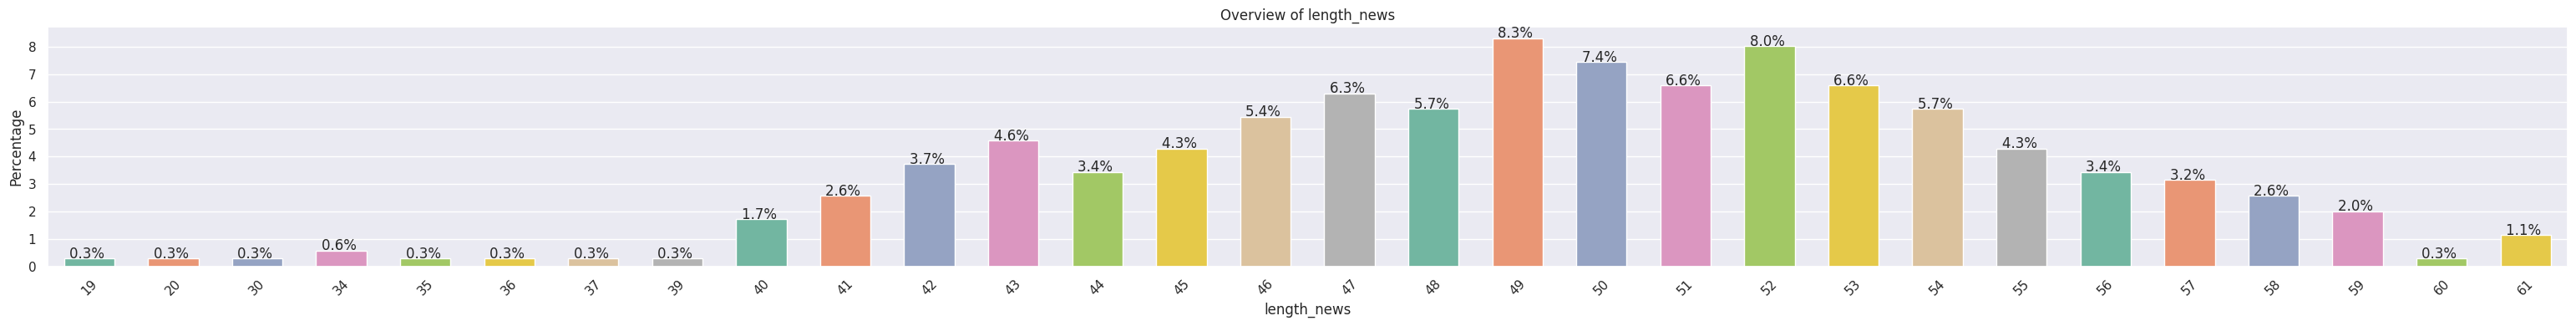

In [116]:
# Plot the bar chart for these news length
plot_bar_chart_percentage(df=data,column_name='length_news',xlabel='length_news',pellete=pellete)

### Observations:
- Highest no of words in news is 61 (1.1%)
- News with 49 words has highest Occournace followed by 52(8%)
- Some of news are very short having around 19-20 words .

### Bivariate AnaLysis

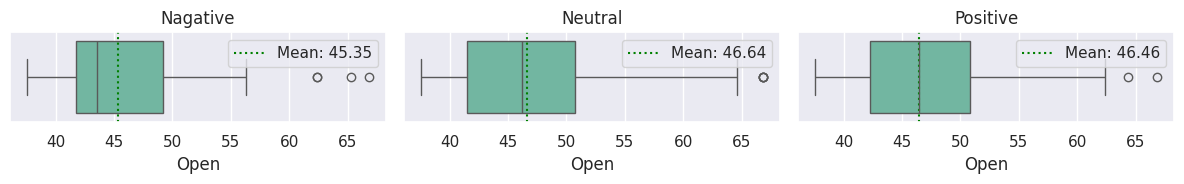

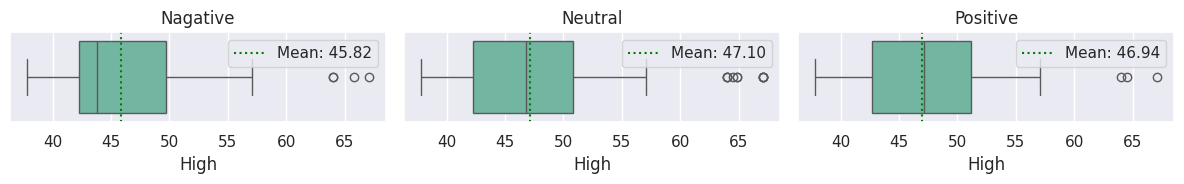

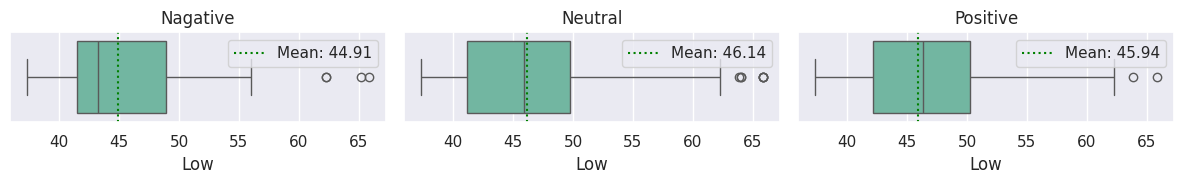

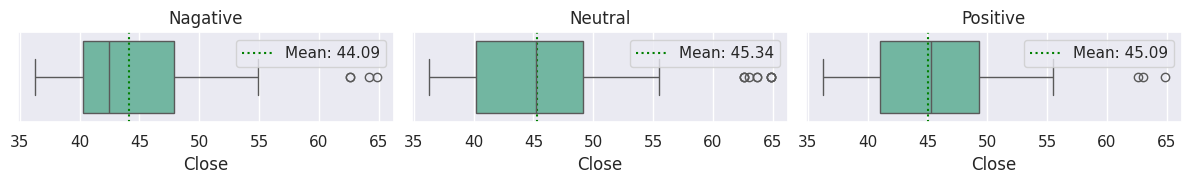

In [68]:
# Check the distribution of price across all seniments.Draw bar chart on Open,High,Low and Close
plot_box_plot_side_by_side(df=data,x='Open',xlabel='Open',category_col='sentiment_label',color=colors[0]);
plot_box_plot_side_by_side(df=data,x='High',xlabel='High',category_col='sentiment_label',color=colors[0]);
plot_box_plot_side_by_side(df=data,x='Low',xlabel='Low',category_col='sentiment_label',color=colors[0]);
plot_box_plot_side_by_side(df=data,x='Close',xlabel='Close',category_col='sentiment_label',color=colors[0]);


### Observations:
- We can see Open and Close price of nagative sentiments has lowest mean 45.35 and 44.09 respectively
- In case of Neutral sentiments the stock price closing shows highest mean (47.10)
- In case of positive sentiments the open Price is at 46.94 and close at 45.09


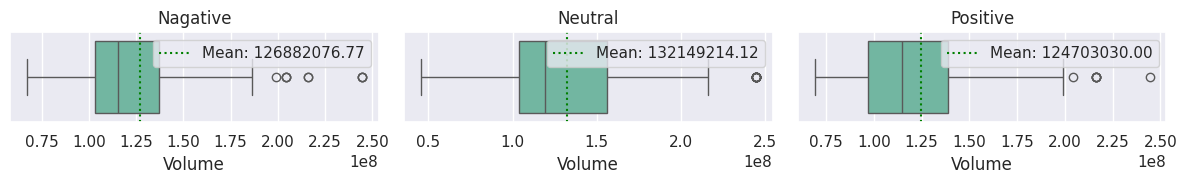

In [73]:
# Volume of shares traded on ecah price
plot_box_plot_side_by_side(df=data,x='Volume',xlabel='Volume',category_col='sentiment_label',color=colors[0]);


### Observations:
- Neutral senitiments has higher volume trades then both nagative and positive
- Nagative sentiments has higher volume trades then positive sentiments

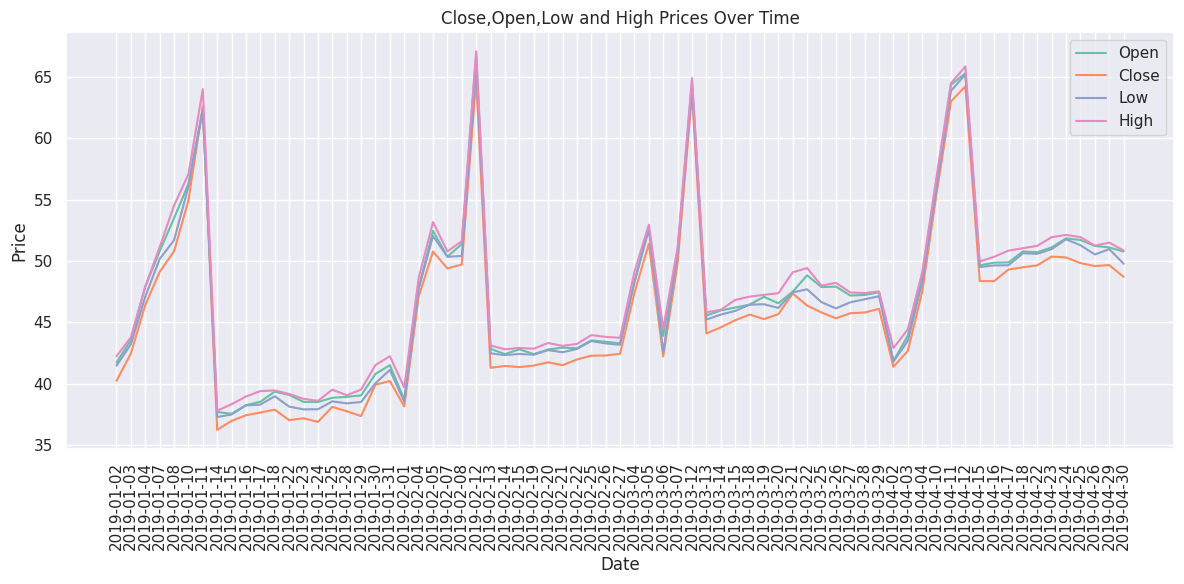

In [96]:
#Check tproce varies across the dates
plt.figure(figsize=(12, 6))
for i,value in enumerate(['Open','Close','Low','High']):
  sns.lineplot(data=data, x='Date', y=value, label=value, color=colors[i])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close,Open,Low and High Prices Over Time')
plt.legend()
plt.tight_layout()
plt.show()

### Observations:
-  Its observed that around 08-02-2019 the price breached 65.
- Its observed that around 14-01-2019 the close price was lowest near to 35.

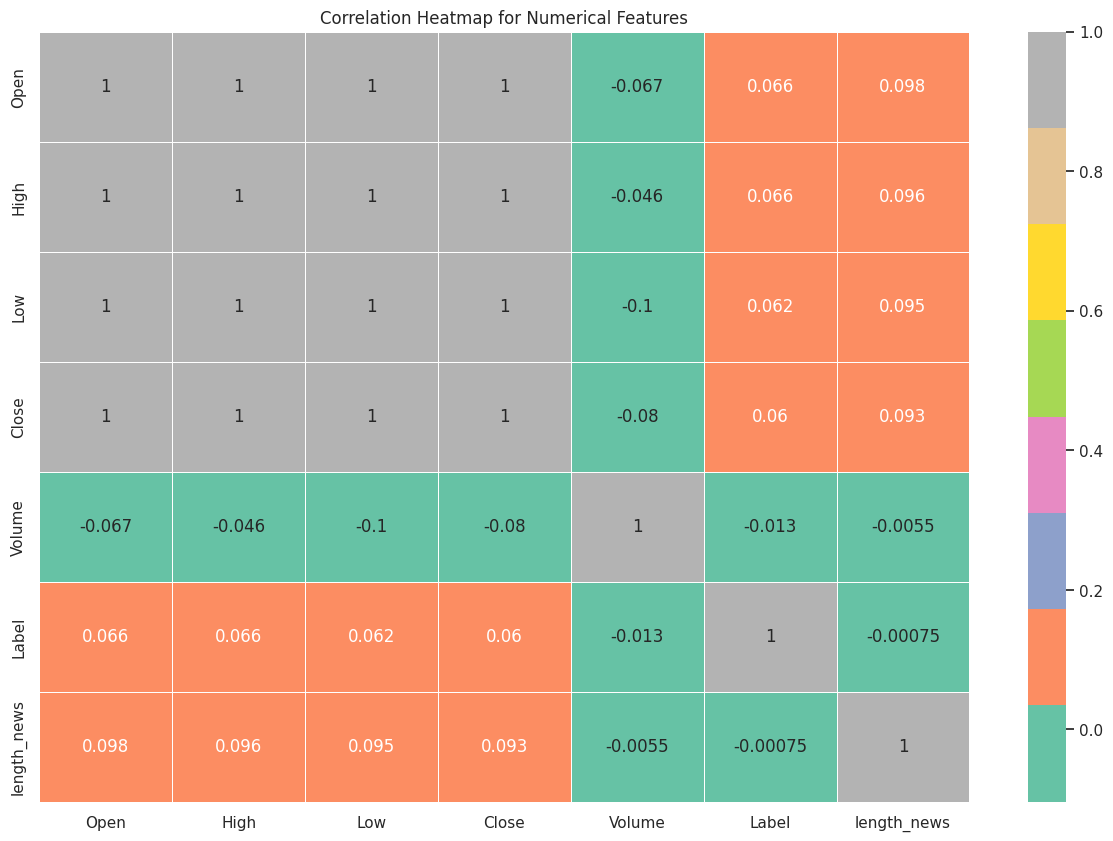

In [117]:
# Coerartion plot
plt.figure(figsize=(15, 10))
sns.heatmap(data.select_dtypes(exclude='object').corr(),annot=True,linewidths=0.5, cmap=pellete)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

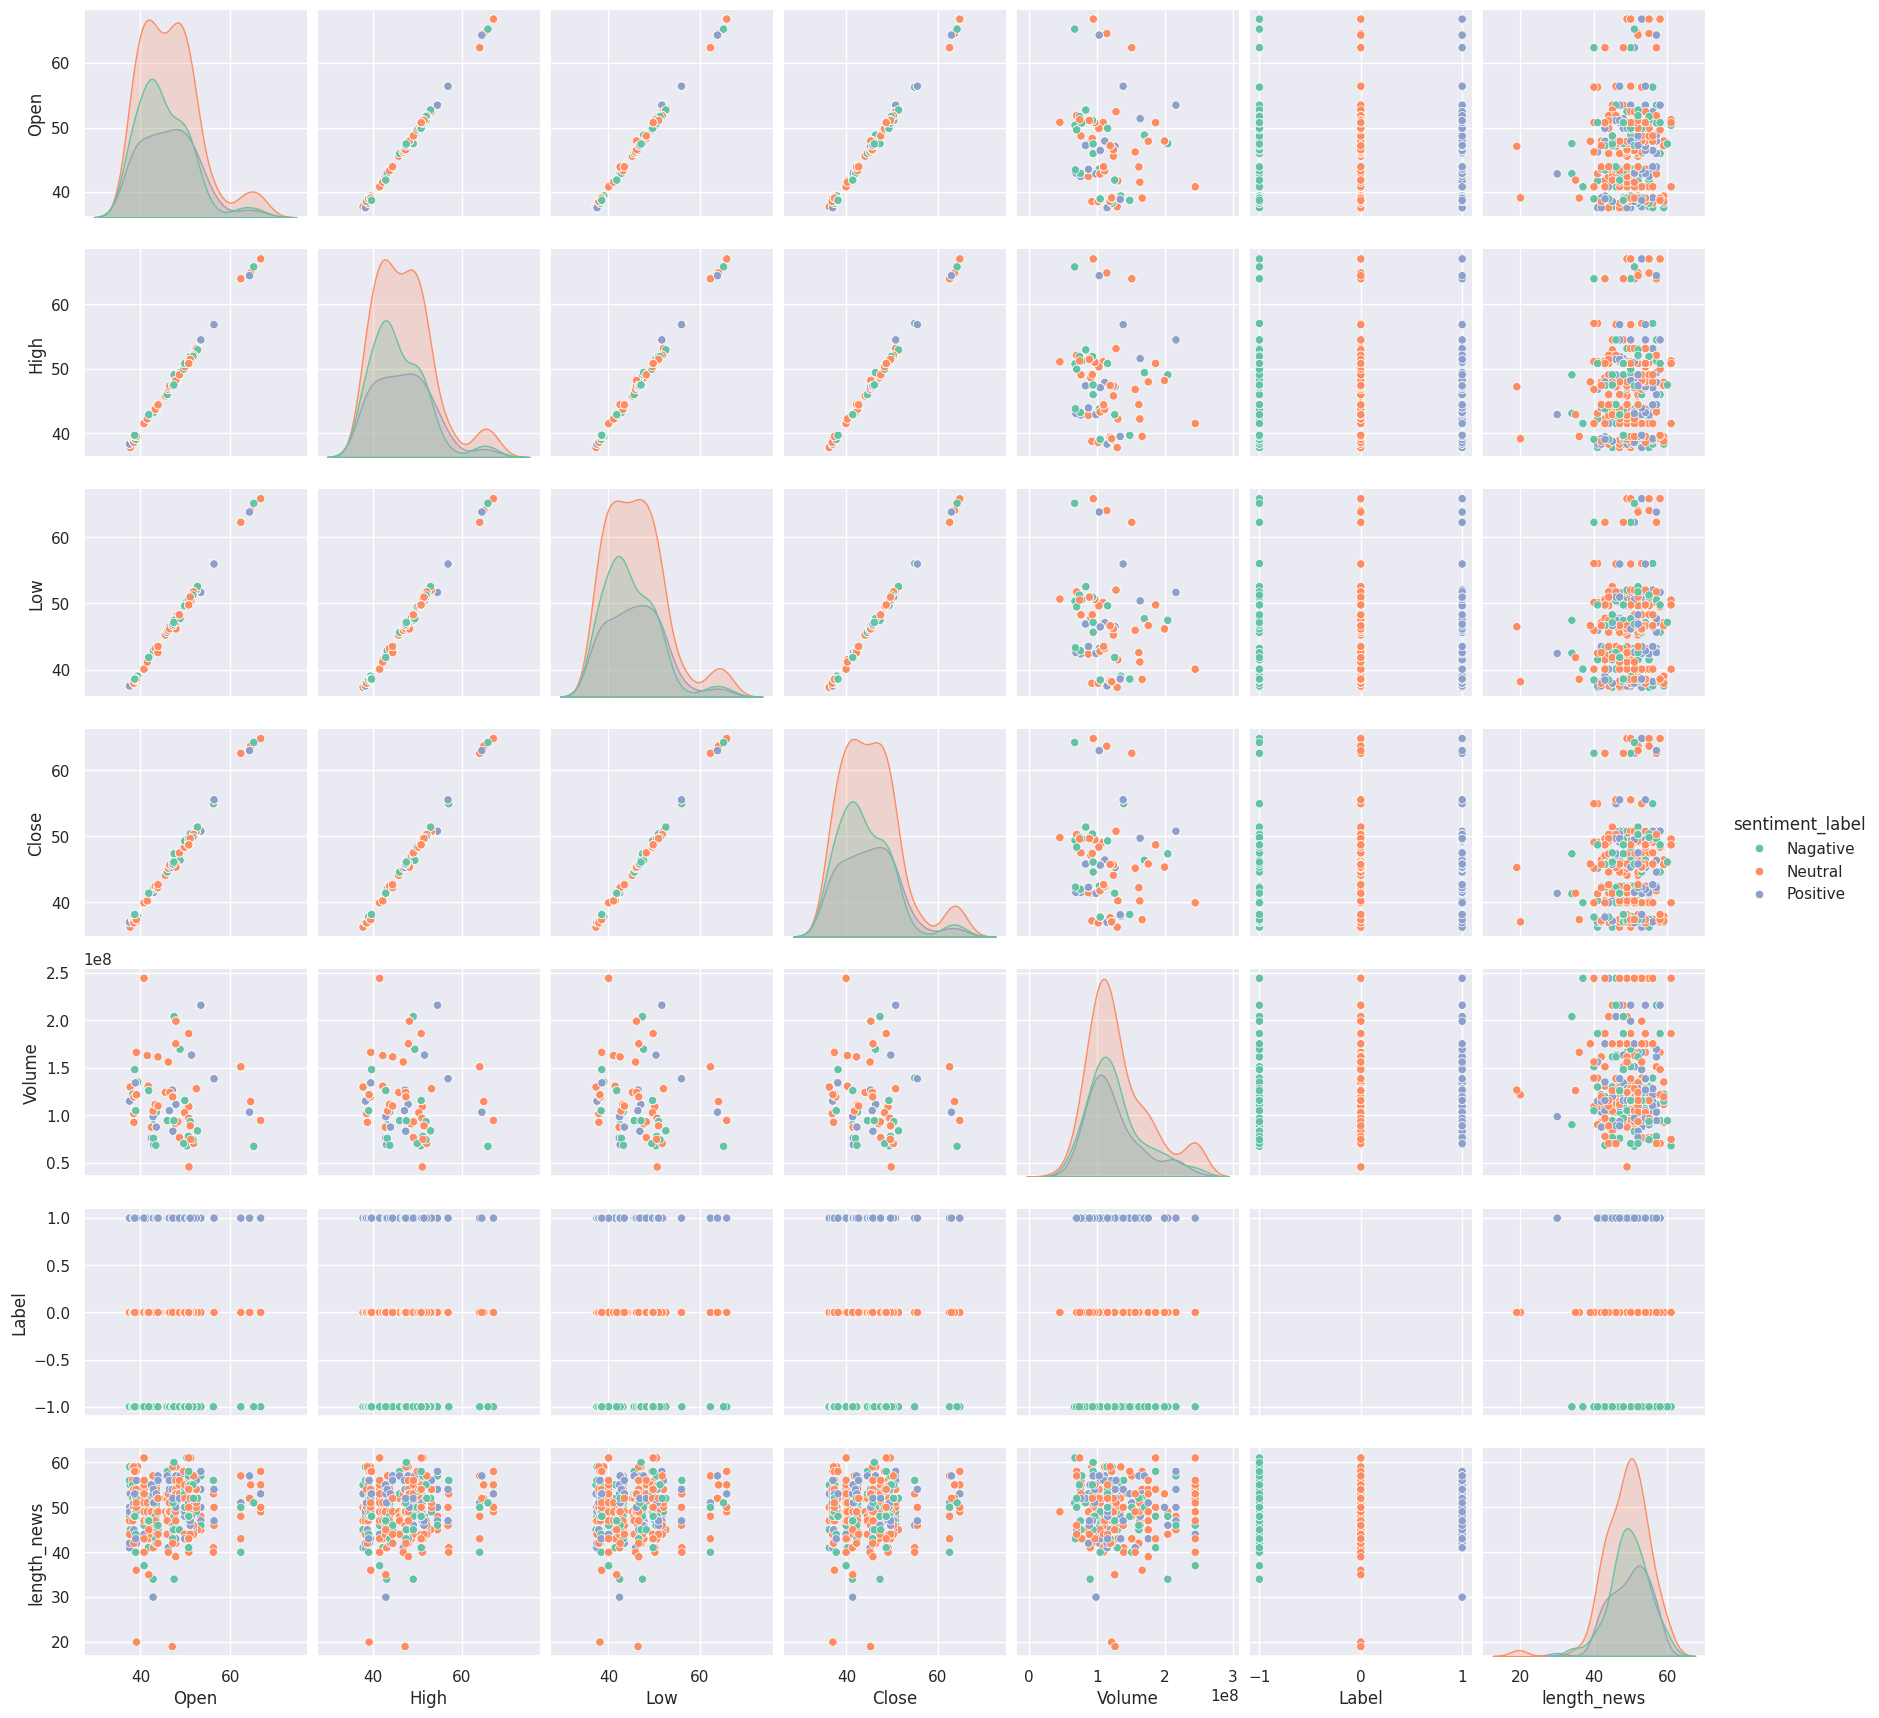

In [122]:
# pair plot to check corelation
sns.pairplot(data=data,hue='sentiment_label',palette=pellete);

### Observations:
-  Only varaible with proce like Open,Close,High,Low are highly corelated .No Other co Relation found